In [2]:
import csv
import numpy as np
import scipy
import networkx as nx
import math
import sys
import os
import subprocess
import scipy.stats
import scipy.optimize
import operator
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

sys.path.append("../Python_code") # go to parent dir
from canvas_vis import * 
from analytics_combined import *
from generate_proj_to_remove import *
from project_data_analysis import *
from user_embedding import *
from segmentation import *
from evaluation import *

ModuleNotFoundError: No module named 'user_embedding'

In [5]:
projects_to_remove = get_list_of_removed_proj(output_filename = "../data/proj_to_remove.txt")

input_file= "../data/sorted_tile_placements_proj.csv"

#Determine the size of the canvas that is being looked at
min_x = 0
max_x = 250
min_y = 0
max_y = 250

#TODO: How far two vertices should be to be connected (1-4)?
G, ups = create_graph(input_file, projects_to_remove, 4, min_x, max_x, min_y, max_y)

print("num edges = ", G.n_edges)

num edges =  35605041


In [6]:
#Defining 7 edge features and computing the information they require
#Adding a new feature without changing the rest of the code should
#be easy.
#TODO: Are there other features that would improve the segmentation?
#TODO: How many dimensions we need?

def different_color(i, j, ups, data=None):
    if ups[i][4] == ups[j][4]:
        return 0
    else:
        return 1
        
def distance_space(i, j, ups, data=None):
    xi = ups[i][2]
    yi = ups[i][3]
    xj = ups[j][2]
    yj = ups[j][3]
    
    return np.sqrt(pow(xi-xj,2)+pow(yi-yj,2))

def distance_time(i, j, ups, data=None):
    time_i = ups[i][0]
    time_j = ups[j][0]
    
    return np.sqrt(pow(time_i-time_j,2))

def distance_duration(i, j, ups, durations):
    return dist_duration(durations[i], durations[j])

def distance_color(i, j, ups, conflicts):
    color_i = ups[i][4]
    color_j = ups[j][4]
    
    if color_i == color_j:
        return 0
    else:
        max_up = len(ups)
        dist = 0
        
        conf_i = []
        if conflicts[i][0] <= max_up:
            conf_i.append(ups[conflicts[i][0]][4])
            
        if conflicts[i][1] <= max_up:
            conf_i.append(ups[conflicts[i][1]][4])
        
        conf_j = []
        if conflicts[j][0] <= max_up:
            conf_j.append(ups[conflicts[j][0]][4])
            
        if conflicts[j][1] <= max_up:
            conf_j.append(ups[conflicts[j][1]][4])
        
        if color_i in conf_j:
            dist = dist + 1
            
        if color_j in conf_i:
            dist = dist + 1
        
        return dist
    
def distance_user_embedding(i, j, ups, data):
    user_i = ups[i][1]
    user_j = ups[j][1]
    user_i_id = data['index'][user_i]
    user_j_id = data['index'][user_j]
    
    return np.linalg.norm(data['emb'][user_i_id]-data['emb'][user_j_id])

def distance_user_colors(i, j, ups, data):
    user_i = ups[i][1]
    user_j = ups[j][1]
    user_i_id = data['index'][user_i]
    user_j_id = data['index'][user_j]
    
    return (1.-data['emb'][user_i_id].todense() * data['emb'][user_j_id].todense().T)[0,0]


conflicts = compute_update_conflicts(ups)
durations = compute_update_durations(ups)
user_color, user_index_color = compute_user_color(ups)

ndim=40
threshold=5
total_samples=100
n_negatives=5
n_iterations=10
user_index, emb = embed_users(G, ups, ndim, threshold, total_samples, n_negatives, n_iterations)

features = [{'name': "different_color", 'func': different_color, 'data': None}, 
    {'name': "distance_space",  'func': distance_space, 'data': None}, 
    {'name': "distance_time", 'func': distance_time, 'data': None}, 
    {'name': "distance_duration", 'func': distance_duration, 'data': durations}, 
    {'name': "distance_color", 'func': distance_color, 'data': conflicts},
    {'name': "distance_user_embedding", 'func': distance_user_embedding, 'data': {'index': user_index, 'emb': emb}},
    {'name': "distance_user_colors", 'func': distance_user_colors, 'data': {'index': user_index_color, 'emb': user_color}}]

python ../../signet/signet.py -l signet_id.txt -i signet.txt -o signet -d 40 -t 5 -s 100
avg pos =  0.320036442179 , n =  7504007
avg neg =  1.0322064146 , n =  613372


In [8]:
from sklearn.ensemble import GradientBoostingRegressor

A,b = build_feat_label_data(G, ups, features, min_x, max_x, min_y, max_y, True)
model = GradientBoostingRegressor(random_state=1, n_estimators=25).fit(A, b)

In [13]:
#Feature statistics

def feature_weight_statistics(G, ups, model, features, projects=None, regions=None):
    '''
    '''
    statistics = {}
    
    region_check = {}
    
    if regions != None:
        for r in regions:
            for u in r:
                region_check[u] = 1
    
    for f in range(len(features)):
        #avg, min, max weights
        sum_weights_in = 0
        min_weight_in = 1e10
        max_weight_in = 0
    
        sum_weights_out = 0
        min_weight_out = 1e10
        max_weight_out = 0
        n_in = 0
        n_out = 0
    
        with open(G.unique_edges_file_name, 'r') as file_in:
            reader = csv.reader(file_in)
    
            for r in reader:
                u = int(r[0])
                v = int(r[1])
                proj_u = ups[u][5]
                proj_v = ups[v][5]
                pixel_u = int(ups[u][6])
                pixel_v = int(ups[v][6])
                
                w = features[f]['func'](u, v, ups, features[f]['data'])
                
                if pixel_u == 1 and pixel_v == 1 and regions is None or (u in region_check and v in region_check):
                    if projects is None or (proj_u in projects and proj_v in projects):
                        if proj_u == proj_v:
                            sum_weights_in = sum_weights_in + w
                            n_in = n_in + 1
            
                            if w < min_weight_in:
                                min_weight_in = w
                
                            if w > max_weight_in:
                                max_weight_in = w
                        else:
                            sum_weights_out = sum_weights_out + w
                            n_out = n_out + 1
            
                            if w < min_weight_out:
                                min_weight_out = w
                
                            if w > max_weight_out:
                                max_weight_out = w                
                
        statistics[features[f]['name']] = {}
        
        statistics[features[f]['name']]['inside avg'] = sum_weights_in / n_in
        statistics[features[f]['name']]['inside min'] = min_weight_in
        statistics[features[f]['name']]['inside max'] = max_weight_in
        statistics[features[f]['name']]['inside count'] =  n_in
    
        statistics[features[f]['name']]['outside avg'] = sum_weights_out / n_out
        statistics[features[f]['name']]['outside min'] = min_weight_out
        statistics[features[f]['name']]['outside max'] = max_weight_out
        statistics[features[f]['name']]['outside count'] =  n_out
    
        statistics[features[f]['name']]['all avg'] = (sum_weights_in+sum_weights_out) / (n_in + n_out)
        statistics[features[f]['name']]['all min'] = min(min_weight_in, min_weight_out)
        statistics[features[f]['name']]['all max'] = max(max_weight_in, max_weight_out)
        statistics[features[f]['name']]['all count'] =  n_in + n_out
        
        
    sum_weights_in = 0
    min_weight_in = 1e10
    max_weight_in = 0
    
    sum_weights_out = 0
    min_weight_out = 1e10
    max_weight_out = 0
    n_in = 0
    n_out = 0
    
    with open(G.unique_edges_file_name, 'r') as file_in:
        reader = csv.reader(file_in)
    
        for r in reader:
            u = int(r[0])
            v = int(r[1])
            proj_u = ups[u][5]
            proj_v = ups[v][5]
            pixel_u = int(ups[u][6])
            pixel_v = int(ups[v][6])
                
            w = compute_weight(int(u), int(v), ups, model, features)
                
            if pixel_u == 1 and pixel_v == 1 and regions is None or (u in region_check and v in region_check):
                if projects is None or (proj_u in projects and proj_v in projects):
                    if proj_u == proj_v:
                        sum_weights_in = sum_weights_in + w
                        n_in = n_in + 1
            
                        if w < min_weight_in:
                            min_weight_in = w
                
                        if w > max_weight_in:
                            max_weight_in = w
                    else:
                        sum_weights_out = sum_weights_out + w
                        n_out = n_out + 1
            
                        if w < min_weight_out:
                            min_weight_out = w
                
                        if w > max_weight_out:
                            max_weight_out = w                
                
    statistics['weight'] = {}
        
    statistics['weight']['inside avg'] = sum_weights_in / n_in
    statistics['weight']['inside min'] = min_weight_in
    statistics['weight']['inside max'] = max_weight_in
    statistics['weight']['inside count'] =  n_in
    
    statistics['weight']['outside avg'] = sum_weights_out / n_out
    statistics['weight']['outside min'] = min_weight_out
    statistics['weight']['outside max'] = max_weight_out
    statistics['weight']['outside count'] =  n_out
    
    statistics['weight']['all avg'] = (sum_weights_in+sum_weights_out) / (n_in + n_out)
    statistics['weight']['all min'] = min(min_weight_in, min_weight_out)
    statistics['weight']['all max'] = max(max_weight_in, max_weight_out)
    statistics['weight']['all count'] =  n_in + n_out
    
    return statistics

In [14]:
feature_weight_statistics(G, ups, model, features, projects=None, regions=None)

{'different_color': {'all avg': 0.5506835397020043,
  'all count': 2948768,
  'all max': 1,
  'all min': 0,
  'inside avg': 0.49820972518183027,
  'inside count': 2435101,
  'inside max': 1,
  'inside min': 0,
  'outside avg': 0.7994420509785523,
  'outside count': 513667,
  'outside max': 1,
  'outside min': 0},
 'distance_color': {'all avg': 0.20388277409413016,
  'all count': 2948768,
  'all max': 2,
  'all min': 0,
  'inside avg': 0.1897297073098816,
  'inside count': 2435101,
  'inside max': 2,
  'inside min': 0,
  'outside avg': 0.27097711163068683,
  'outside count': 513667,
  'outside max': 2,
  'outside min': 0},
 'distance_duration': {'all avg': 0.4178737626877978,
  'all count': 2948768,
  'all max': 1.0,
  'all min': 0.0,
  'inside avg': 0.4081432360968296,
  'inside count': 2435101,
  'inside max': 1.0,
  'inside min': 0.0,
  'outside avg': 0.4640025095845095,
  'outside count': 513667,
  'outside max': 1.0,
  'outside min': 0.0},
 'distance_space': {'all avg': 3.444402414

In [9]:
#Feature importances

for f in range(len(features)):
    print("feature: ", features[f]['name'], model.feature_importances_[f])

feature:  different_color 0.187636959339
feature:  distance_space 0.226454449382
feature:  distance_time 0.0258947641363
feature:  distance_duration 0.0325062422559
feature:  distance_color 0.00156483016551
feature:  distance_user_embedding 0.489317179888
feature:  distance_user_colors 0.0366255748332


In [10]:
compute_edge_weights(G, ups, model, features)
G.sort_edges()

In [20]:
comp_assign = region_segmentation(G, ups, .2)
regions, sizes = extract_regions(comp_assign)

print("num regions = ", len(regions), " max size region = ", np.max(sizes))

num regions =  199363  max size region =  6237


In [ ]:
locations = store_locations("../data/atlas_complete.json")

In [ ]:
# TEST THE REGION OVERLAP PERCENTAGES
overlap_statistics = compute_overlap_area(locations, regions[0], ups, ground_truth)

In [ ]:
#Keeping only final pixels from the regions

pixel_assign = assign_pixels(comp_assign, ups)
regions, sizes = extract_regions(pixel_assign)

In [ ]:
def super_pixel_graph(G, comp_assign, ups):
    num_edges = {}
    total_weight = {}
    
    sG = nx.Graph()
    
    open(G.sorted_edges_file_name, 'r') as file_in:
        reader = csv.reader(file_in)
        
        for r in reader:
            u = int(r[0])
            v = int(r[1])
            lb = r[2]
            w = float(r[3])
            
            r1 = comp_assign[u]
            r2 = comp_assign[v]
            
            if (r1,r2) not in num_edges:
                num_edges[(r1,r2)] = 1
                total_weight[(r1,r2)] = 1
            else:    
                num_edges[(r1,r2)] = num_edges[(r1,r2)] + 1
                total_weight[(r1,r2)] = total_weight[(r1,r2)] + 1
            
            sG.add_edge(r1, r2)
    
    for e in sG.edges():
        nx.set_edge_attributes(sG, 'count', num_edges[e])
        nx.set_edge_attributes(sG, 'total_weight', total_weight[e])
    
    return sG

In [ ]:
def assign_region_to_proj(regions, ups, pixel=False):
    for r in range(len(regions)):
        region = regions[r]
        projs = {}
        
        for u in region:
            proj = ups[u][5]
            
            if pixel is True:
                if int(ups[u][6]) == 1:
                    if proj not in projs:
                        projs[proj] = 1
                    else:
                        projs[proj] = projs[proj] + 1
            elif int(ups[u][7]) == 1:
                    if proj not in projs:
                        projs[proj] = 1
                    else:
                        projs[proj] = projs[proj] + 1
                        
        max_proj, count = max(projs.iteritems(), key=operator.itemgetter(1))
            
        region_proj.append(max_proj)
        
    return region_proj

In [ ]:
def compute_user_vector_regions(regions, user_color, user_index_color, ups):
    user_color_regions = np.zeros((len(regions), 16))
    
    for r in range(len(regions)):
         
        for u in regions[r]:
            up = regions[r][u]
            user = ups[up][1]
            idx_user = user_index_color[user]
            user_color_regions[r] = user_color_regions[r] + user_color[idx_user]
            
        user_color_regions[r] = user_color_regions[r] / len(regions[r])
            
    return user_color_regions

In [ ]:
def compute_region_durations(regions, durations, ups):
    duration_regions = np.zeros((len(regions, 2)))
    
    for r in range(len(regions)):
        begin = sys.maxsize
        end = 0
        
        for u in regions[r]:
            up = regions[r][u]
            begin = min(durations[up][0], begin)
            end = max(durations[up][1], end)
            
        duration_regions[r][0] = begin
        duration_regions[r][1] = end
    return duration_regions

In [ ]:
def compute_regions_center_position(regions, ups)
    '''
        Computes center position (average) of a region based on updates.
    '''
    center_regions = np.zeros((len(regions),2))
    
    for r in range(len(regions)):
        for u in regions[r]:
            up = regions[r][u]
            x = ups[up][2]
            y = ups[up][3]
            
            center_regions[r][0] = center_regions[r][0] + x
            center_regions[r][1] = center_regions[r][1] + y
            
        center_regions[r][0] = center_regions[r][0] / len(regions[r])
        center_regions[r][1] = center_regions[r][1] / len(regions[r])
            
    return center_regions

In [ ]:
def compute_region_colors(regions, ups):
    region_colors = np.zeros((len(regions), 16))
    
    for r in range(len(regions)):
        region = regions[r]
        for u in region:
            c = int(ups[u][4])
            
            region_colors[r][c] = region_colors[r][c] + 1
            
        region_colors[r] = region_colors[r] / region_colors[r].sum()
        
    return region_colors

In [ ]:
#How to build graph of regions? Edges should capture proximity between regions.
#    - Closest pixel (Seems best)

#How to merge regions over different times?
#    - Total of incompatible updates
#    - Time overlap between regions (is there a way to capture density?)

#How to tune the weights?
#    - Mark edges for which merging would match IoU criteria as positive

def compute_regions_overlap(regions, ups)
    '''
        
    '''
    overlap_regions = np.zeros((len(regions),len(regions)))
    
    for r1 in range(len(regions)):
        for r1 in range(len(regions)):
            
            for u in regions[r]:
                up = regions[r][u]
                x = ups[up][2]
                y = ups[up][3]
            
            center_regions[r][0] = center_regions[r][0] + x
            center_regions[r][1] = center_regions[r][1] + y
            
        center_regions[r][0] = center_regions[r][0] / len(regions[r])
        center_regions[r][1] = center_regions[r][1] / len(regions[r])
            
    return center_regions

In [45]:
A,b = build_feat_label_data(G, ups, features)

In [80]:
train_perc = 0.5
n_samples = A.shape[0]
n_samples_train = int(n_samples * train_perc)

shuff = np.arange(n_samples)
np.random.shuffle(shuff)

A = A[shuff]
b = b[shuff]

m = learn_model(A[0:n_samples_train,:],b[0:n_samples_train], 'gb')

In [81]:
print("training MSE = ", ((b[:n_samples_train]- m.predict(A[0:n_samples_train,:]))**2).mean(axis=0) )

training MSE =  0.0935236967968


In [82]:
print("test MSE = ", ((b[n_samples_train:]- m.predict(A[n_samples_train:,:]))**2).mean(axis=0) )

test MSE =  0.0932731528227


In [127]:
m.predict(A[n_samples_train:,:])

array([ 0.05327036,  0.06523364,  0.02242783, ...,  0.04141286,
        0.13929122,  0.02699247])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=25, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=False)

In [84]:
#A[i][0] = user_color_weight
#A[i][1] = user_weight
#A[i][2] = dur_weight
#A[i][3] = color_conf_weight
#A[i][4] = dist_space
#A[i][5] = dist_time
#A[i][6] = color_diff

m.feature_importances_

array([ 0.02473231,  0.51514431,  0.04639676,  0.01617578,  0.18877407,
        0.05549622,  0.15328055])

In [47]:
compute_edge_weights(G, ups, model, features)
G.sort_edges()

In [48]:
comp_assign = region_segmentation(G, ups, .2)
regions, sizes = extract_regions(comp_assign)

print("num regions = ", len(regions), " max size region = ", np.max(sizes))

In [199]:

#regions, sizes = extract_regions(comp_assign)

In [39]:
def draw_top_regions(k, output_file_name='../plots/top_region'):
    ind  = np.argsort(sizes)
    
    for i in range(1, k):
        ups_region = updates_region(ups, regions[ind[-i]])
        
        plt.close('all')

        canvas_ups = extract_canvas_updates(ups_region)
        canvas_ups_rgb = canvas_color_code_rgb(canvas_ups)

        draw_canvas(canvas_ups_rgb, output_file_name+"_"+str(i)+".svg")

In [40]:
draw_top_regions(10)

In [93]:
len(ups_max_region)

4589

In [151]:
len(regions)

129014

In [49]:
def region_statistics(G, region, ups):
    #avg, min, max weights
    sum_weights_in = 0
    min_weight_in = 1e10
    max_weight_in = 0
    
    sum_weights_out = 0
    min_weight_out = 1e10
    max_weight_out = 0
    n_in = 0
    n_out = 0
    
    n_edges = 0
    region_check = {}
    
    for u in region:
        region_check[u] = 1
    
    with open(G.sorted_edges_file_name, 'r') as file_in:
        reader = csv.reader(file_in)
    
        for r in reader:
            u = int(r[0])
            v = int(r[1])
            w = float(r[4])
            
            if u in region_check and v in region_check:
                n_edges = n_edges + 1
                sum_weights_in = sum_weights_in + w
                n_in = n_in + 1
            
                if w < min_weight_in:
                    min_weight_in = w
                
                if w > max_weight_in:
                    max_weight_in = w
                    
            elif u in region_check or v in region_check:
                sum_weights_out = sum_weights_out + w
                n_out = n_out + 1
            
                if w < min_weight_out:
                    min_weight_out = w
                
                if w > max_weight_out:
                    max_weight_out = w
    
    color_dist = np.zeros(16)
    n_pixel = 0
    n_pixel_color = 0
    for u in region:
        if ups[u][6] == 1:
            n_pixel = n_pixel + 1
        if ups[u][7] == 1:
            n_pixel_color = n_pixel_color + 1
        
        color_dist[int(ups[u][4])] = color_dist[int(ups[u][4])] + 1
    
    print("num updates = ", len(region))
    print("num_edges = ", n_edges)
    print("num pixels = ", n_pixel, " (", 100 * n_pixel / len(region), "%)")
    print("num_pixel_colors = ", n_pixel_color, " (", 100 * n_pixel / len(region), "%)")
    
    print()
    
    print("colors: ", list(color_dist))
        
    print()
    
    print("avg weight inside = ",  sum_weights_in / n_in)
    print ("min weight inside = ", min_weight_in)
    print("max weight inside = ", max_weight_in)
    print("#edges inside = ", n_in)
    
    print()
    
    print("avg weight outside = ",  sum_weights_out / n_out)
    print ("min weight outside = ", min_weight_out)
    print("max weight outside = ", max_weight_out)
    print("#edges outside = ", n_out)
    
    

In [21]:
def weight_statistics(G, ups, projs):
    #avg weight inside final
    #avg weight outside final
    #avg weight final
    
    sum_in_final = 0
    sum_out_final = 0
    n_in_final = 0
    n_out_final = 0
    
    #avg weight inside color
    #avg weight outside color
    #avg weight final color
    
    sum_in_color = 0
    sum_out_color = 0
    n_in_color = 0
    n_out_color = 0
    
    #avg weight unlabelled
    
    #avg weight outside final unlabelled
    #avg weight outside final color unlabelled
    
    with open(G.sorted_edges_file_name, 'r') as file_in:
        reader = csv.reader(file_in)
    
        for r in reader:
            u = int(r[0])
            v = int(r[1])
            w = float(r[4])
            type_edge = int(r[3])
            proj_u = ups[u][5]
            proj_v = ups[v][5]
            
            if type_edge > 0:
                if projs is None or (proj_u in projs and proj_v in projs):
                    if ups[u][6] == 1 and ups[v][6] == 1:
                        if ups[u][5] == ups[v][5]:
                            sum_in_final = sum_in_final + w
                            n_in_final = n_in_final + 1
                        else:
                            sum_out_final = sum_out_final + w
                            n_out_final = n_out_final + 1

                    if ups[u][7] == 1 and ups[v][7] == 1:
                        if ups[u][5] == ups[v][5]:
                            sum_in_color = sum_in_color + w
                            n_in_color = n_in_color + 1
                        else:
                            sum_out_color = sum_out_color + w
                            n_out_color = n_out_color + 1
                            
                    
                    
    print("avg weight inside projects (pixel) = ", sum_in_final / n_in_final)
    print("avg weight outside projects (pixel) = ", sum_out_final / n_out_final)
    print("avg weight (pixel) = ", (sum_in_final + sum_out_final) / (n_in_final + n_out_final) )
    
    print()
    
    print("avg weight inside projects (color) = ", sum_in_color / n_in_color)
    print("avg weight outside projects (color) = ", sum_out_color / n_out_color)
    print("avg weight (color) = ", (sum_in_color + sum_out_color) / (n_in_color + n_out_color) )
    

In [89]:
weight_statistics(G, ups, ['339', '241'])

avg weight inside projects (pixel) =  0.1068773950334158
avg weight outside projects (pixel) =  0.1685631578045931
avg weight (pixel) =  0.10930372073242092

avg weight inside projects (color) =  0.11445576818903837
avg weight outside projects (color) =  0.1730427318100387
avg weight (color) =  0.11655832022259469


In [50]:
region_statistics(G, regions[ind[-3]], ups)

num updates =  3916
num_edges =  18767
num pixels =  10  ( 0.2553626149131767 %)
num_pixel_colors =  3551  ( 0.2553626149131767 %)

colors:  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

avg weight inside =  0.05425757137124983
min weight inside =  0.0236806037521
max weight inside =  0.139680634876
#edges inside =  18767

avg weight outside =  0.15324475357323653
min weight outside =  0.0288072459221
max weight outside =  0.502583693909
#edges outside =  67394


In [139]:
reg_339, sizes_339 = regions_with_proj(ups, regions, '241')
ind  = np.argsort(sizes_339)

In [113]:
ups[1000]

[1490992900000, '5UNAKBUeEj9Koq76ThA5sG3Xxak=', 27, 30, 13, '73', 0, 0]

In [114]:
ups[10089]

[1491071011000, 'N/4Uax/XxQPMrREHoJOU/BoTzIY=', 22, 43, 3, '241', 0, 1]

In [117]:
user_i_id = user_index_color['5UNAKBUeEj9Koq76ThA5sG3Xxak=']
user_j_id = user_index_color['5UNAKBUeEj9Koq76ThA5sG3Xxak=']

(1.-user_color[user_i_id].todense() * user_color[user_j_id].todense().T)[0,0]

2.2204460492503131e-16

In [118]:
user_color[user_i_id].todense()

matrix([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.70710678,  0.        ,
         -0.70710678]])

In [119]:
user_color[user_j_id].todense()

matrix([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.70710678,  0.        ,
         -0.70710678]])

In [31]:
G_proj, node_colors, edge_colors = proj_graph(G, ups, ['339', '241'], True)

<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

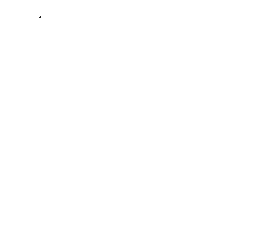

In [107]:
canvas_ups = extract_canvas_updates(updates_region(ups, reg_339[ind[-2]]))
canvas_ups_rgb = canvas_color_code_rgb(canvas_ups)

draw_canvas(canvas_ups_rgb, "../plots/max_region.svg")

In [54]:
len(ups)

180462

In [64]:
len(regions)

149497

In [31]:
ground_truth = create_ground_truth(input_file,0, sys.maxsize, min_x, max_x, min_y, max_y)

In [32]:
print(len(ground_truth))

20


In [33]:
'''
Perform the evaluation only on the final canvas. Generate a new graph consisting of only final updates
'''

G_final, ups = create_graph(input_file, 0, sys.maxsize, 2, 30*60, min_x, max_x, min_y, max_y,  True)

In [168]:
if os.path.exists(G_final.edges_file_name):
    os.remove(G_final.edges_file_name)
with open(G_final.unique_edges_file_name, 'r') as file_in:
    reader = csv.reader(file_in)
    
    for r in reader:
        u = r[0]
        v = r[1]
        lb = r[2]
        
        w = compute_weight(int(u), int(v), ups[int(u)], ups[int(v)], [usr_rel_same_color, usr_rel_diff_color], 
             user_index, durations, user_color, user_index_color, [0.1, 0.1, 0.8], 0.9, 0.9)
        
        G_final.set_weight(u, v, lb, w)
        
G_final.flush_weights()

In [169]:
G_final.sort_edges()

In [170]:
locations = store_locations("../data/atlas_complete.json")

In [171]:
comp_assign = region_segmentation(G_final, 0.9)

In [172]:
regions, sizes = extract_regions(comp_assign)

In [173]:
print(len(regions))
num_single = 0
non_single_regions = []
for region in regions:
    if len(region) == 1:
        num_single += 1
    else:
        non_single_regions.append(region)
print(num_single)
print(len(non_single_regions))

210747
209836
911


630
1493


<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

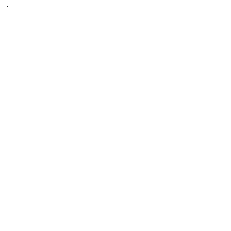

In [179]:
 num_correct_counter, num_assignments_made, precision, recall, region_assignments = evaluate(locations, non_single_regions, ups, ground_truth, 0.5, draw = True)

In [176]:
for pic_id in region_assignments:
    print(pic_id)

630
1493


In [180]:
print("Regions:", len(regions))
print("Total correct assignments:", num_correct_counter)
print("Total assignments made:", num_assignments_made)
print("Ground truth size:", len(ground_truth))
print("Precision:", precision)
print("Recall:", recall)

Regions: 210747
Total correct assignments: 2
Total assignments made: 911
Ground truth size: 20
Precision: 0.0021953896816684962
Recall: 0.1


In [16]:
'''
    Run the evaluation function for multiple values of ALPHA, EPSILON, KAPPA
    Write the results of the precision and recall to a file
    
    ALPHA[0] * color_weight + ALPHA[1] * user_weight + ALPHA[2] * dur_weight
'''
evaluation_filename = "../data/evaluation_tests_refactored2.csv"
locations = store_locations("../data/atlas_complete.json")



with open(evaluation_filename, 'w') as file_out:
    writer = csv.writer(file_out, delimiter = ",")
    writer.writerow(["ALPHA_color", "ALPHA_user", "ALPHA_duration", "EPSILON_COLOR", "EPSILON_USER", "KAPPA", "#Regions", "total correct assignments", "Precision", "Recall"])
    
    
#     alphas = [0.20, 0.25, 0.30, 0.35, 0.4]
#     epsilons = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
#     kappas = [0.85,0.9, 0.95, 1, 1.05]
    
    alphas = [0.1, 0.25, 0.33, 0.49, 0.8]
    epsilons = [0.1, 0.3, 0.5, 0.9]
    kappas = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]

#     alphas = [0.05, 0.1, 0.15, 0.20, 0.08, 0.13]
#     epsilons = [0.1, 0.3, 0.5, 0.9]
#     kappas = [0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 2]
    
    iteration = 0
    for alpha0 in alphas:
        for alpha1 in alphas:
            alpha2 = 1 - alpha0 - alpha1
            if alpha2 < 0:
                continue
    
            for epsilon in epsilons:
                for kappa in kappas:

                    print("iteration:", iteration)
                    i = 0

                    if os.path.exists(G_final.edges_file_name):
                        os.remove(G_final.edges_file_name)

                    with open(G_final.unique_edges_file_name, 'r') as file_in:
                        reader = csv.reader(file_in)

                        for r in reader:
                            u = r[0]
                            v = r[1]
                            lb = r[2]

                            w = compute_weight(int(u), int(v), ups[int(u)], ups[int(v)], [usr_rel_same_color, usr_rel_diff_color], 
                                 user_index, durations, user_color, user_index_color, [alpha0, alpha1, alpha2], epsilon, epsilon)

                            G_final.set_weight(u, v, lb, w)

                    G_final.flush_weights()
                    G_final.sort_edges()
                    comp_assign = region_segmentation(G_final, ups, kappa)
                    regions, sizes = extract_regions(comp_assign)

                    num_correct_counter, num_assignments_made, precision, recall, region_assignments = evaluate(locations, regions, ups, ground_truth, 0.50)


                    writer.writerow([alpha0, alpha1, alpha2, epsilon, epsilon, kappa, len(regions), num_correct_counter, precision, recall])

                    iteration += 1


iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

KeyboardInterrupt: 

In [211]:
def updates_region(ups, region):
    ups_region = []
    
    for u in sorted(region):
        ups_region.append(ups[int(u)])
        
    return ups_region

ind  = np.argsort(sizes)

ups_max_region = updates_region(ups, regions[ind[-1]])

In [213]:
ups_max_region = updates_region(ups, regions[ind[-2]])

In [218]:
def extract_canvas_updates(updates):
    data_color_code = np.uint8(np.zeros((1001,1001)))
    
    for u in updates:
        x = u[2]
        y = u[3]
        color = u[4]
        
        data_color_code[y][x] = color
        
    return data_color_code

canvas_ups = extract_canvas_updates(ups)
canvas_ups_rgb = canvas_color_code_rgb(canvas_ups)

draw_canvas(canvas_ups_rgb, "../plots/frame.svg")

<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

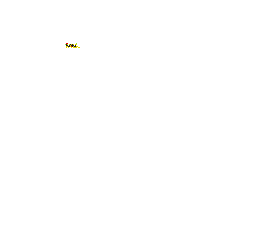

In [214]:
canvas_ups = extract_canvas_updates(ups_max_region)
canvas_ups_rgb = canvas_color_code_rgb(canvas_ups)

draw_canvas(canvas_ups_rgb, "../plots/max_region.svg")

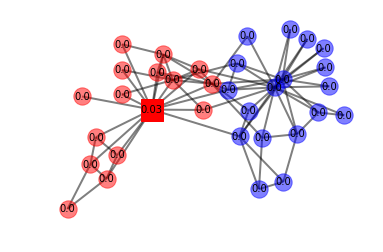

In [110]:
import array
import networkx as nx
import numpy as np
import queue 
import sys
import operator

def create_idx(G):
    '''
        Associates each vertex in G to an integer from 0 ... number-of-vertices minus one.
    '''
    idx = {}
    for v in G.nodes():
        idx[v] = len(idx)
        
    return idx

def push(G, u, p, r, alpha, idx, weight=None):
    '''
        Push operation for approximate pagerank. Updates probability and residual vectors 
        based on a single vertex u.
    '''
    idx_u = idx[u]
    
    p[idx_u] = p[idx_u] + alpha * r[idx_u]
    
    deg_u = G.degree(u, weight=weight)
        
    for v in G.neighbors(u):
        idx_v = idx[v] 
        
        if weight is None:
            w = 1. / deg_u
        else:
            w = G[u][v][weight] / deg_u
        
        r[idx_v] = r[idx_v] + 0.5 * w * (1.-alpha) * r[idx_u]
     
    r[idx_u] = 0.5 * (1.-alpha) * r[idx_u]
    
    return p, r

def approximate_pagerank(G, v, alpha, epsilon, idx, weight=None):
    '''
        Computes approximate personalized pagerank vector for vertex v.
        alpha is the teleportation probability and epsilon is the error.
        
        Uses a queue to keep vertices with residual values higher than 
        allowed.
    '''
    p = np.zeros(G.number_of_nodes())
    r = np.zeros(G.number_of_nodes())
    
    #For quickly checking which vertices are in the queue
    in_queue = array.array('B', [0] * G.number_of_nodes())
  
    Q = queue.Queue(maxsize=G.number_of_nodes()) 
    
    #Initialization
    idx_v = idx[v]
    in_queue[idx_v] = 1
    r[idx_v] = 1.
    Q.put(v)
    
    while Q.empty() is False:
        
        #Retrieving vertex from queue
        u = Q.get()
        idx_u = idx[u]
        deg_u = G.degree(u, weight=weight)
        
        while (r[idx_u] / deg_u) < epsilon and Q.empty() is False:
            in_queue[idx_u] = 0   
            u = Q.get()
            idx_u = idx[u]
            deg_u = G.degree(u, weight=weight)
            
        while (r[idx_u] / deg_u) >= epsilon:
            #Push for vertex u.
            p, r = push(G, u, p, r, alpha, idx, weight)
            
            #Checking whether neighbors of u should be added to queue
            for n in G.neighbors(u):
                idx_n = idx[n]
                deg_n = G.degree(n, weight=weight)
                
                if r[idx_n] / deg_n >= epsilon and in_queue[idx_n] != 1:
                    in_queue[idx_n] = 1
                    Q.put(n)
                                        
        in_queue[idx_u] = 0
                    
    return p

def sweep(G, p, idx, weight):
    '''
        Sweeping algorithm for computing the cut (S,V/S) with minimum conductance based on 
        vertices sorted according to their value in the probability vector p.
    '''
    sweep_vec = {}
    total_vol = 0.
    min_conduct = sys.float_info.max
    best_cut = None
    
    for v in G.nodes():
        #value = p[v] / deg[v]
        sweep_vec[v] = p[idx[v]] / G.degree(v, weight=weight)
        total_vol = total_vol + G.degree(v, weight=weight)
        
    sorted_sweep_vec = sorted(sweep_vec.items(), key=operator.itemgetter(1), reverse=True)
    vol = 0.
    cut = 0.
    
    #For quickly checking vertices in the set S
    in_s = array.array('B', [0] * G.number_of_nodes())
            
    for i in range(len(sorted_sweep_vec)-1):
        v = sorted_sweep_vec[i][0]
        
        #Updating volume of S
        vol = vol + G.degree(v, weight=weight)
        min_vol = min(vol, total_vol-vol)
        
        #Updating total weight of the cut
        for u in G.neighbors(v):
            if weight is None:
                w = 1.
            else:
                w = G[u][v][weight]
                    
            if in_s[idx[u]] == 1:
                cut = cut - w
            else:
                cut = cut + w
                
        in_s[idx[v]] = 1
        
        #conductance
        conduct = cut / min_vol
        
        #print("cut = ", cut, " conductance = ", conduct, " min_vol = ", min_vol, " min_conductance = ", min_conduct)
        
        if conduct <= min_conduct:
            min_conduct = conduct
            best_cut = i
          
    #Creating set S for the optimal cut    
    S = []
    for i in range(best_cut+1):
        S.append(sorted_sweep_vec[i][0])
        
    return S, min_conduct

def pagerank_cut(G, v,  alpha, epsilon, weight):
    '''
        Algorithm for minimum conductance cut (S,V/S) around the neighborhood
        of a particular vertex v. Approximate pagerank vector can be computed
        fast based on local updates. Cut is computed using a sweep procedure
        over pagerank vector.
    '''
    idx = create_idx(G)
    p = approximate_pagerank(G, v, alpha, epsilon, idx, weight)
    S, conduct = sweep(G, p, idx, weight)
    
    probs = {}
    for v in G.nodes():
        probs[v] = p[idx[v]]
    
    return S, probs, conduct

G = nx.karate_club_graph()
v = 0
S, probs, conduct = pagerank_cut(G, v,  .01, 0.01, None)

P1 = []
P2 = []
labels = {}

for u in G.nodes():
    labels[u] = np.around(probs[u], decimals=2)
    if u not in S:
        P2.append(u)
    elif u != v:
        P1.append(u)

pos = nx.fruchterman_reingold_layout(G)

nx.draw_networkx_nodes(G,pos,node_color='red', nodelist=P1,node_size=300, alpha=0.5)
nx.draw_networkx_nodes(G,pos,node_color='blue', nodelist=P2,node_size=300, alpha=0.5)
nx.draw_networkx_nodes(G,pos,node_color='red', nodelist=[v],node_size=500, node_shape='s')
nx.draw_networkx_labels(G,pos=pos,labels=labels,font_size=10)
nx.draw_networkx_edges(G, pos, width=2, edge_color='black', style='solid', alpha=0.5)

limits=plt.axis('off')
plt.savefig("pagerank_cut.png", bbox_inches='tight', pad_inches=0, dpi=1000) 
plt.show() 

In [109]:
probs

{0: 0.11731583868654788,
 1: 0.053792510236789,
 2: 0.055373349029618664,
 3: 0.036509313626549716,
 4: 0.02034488003133287,
 5: 0.026739841807770354,
 6: 0.026752474349439132,
 7: 0.0243974197686955,
 8: 0.027173437755281343,
 9: 0.010213775636167086,
 10: 0.020357512578127575,
 11: 0.0071673130916422856,
 12: 0.013131438629553478,
 13: 0.029193808451711718,
 14: 0.009527845655530668,
 15: 0.009527845655530668,
 16: 0.013088616253128167,
 17: 0.013025872925719348,
 18: 0.009527845655530668,
 19: 0.017822261608735537,
 20: 0.009527845655530668,
 21: 0.013025872925719348,
 22: 0.009527845655530668,
 23: 0.023575487641905781,
 24: 0.01454795375675989,
 25: 0.01442837853566142,
 26: 0.0093692142281897178,
 27: 0.019548837401201127,
 28: 0.01527682625841301,
 29: 0.018701403993761093,
 30: 0.020693568975494007,
 31: 0.031114269788417127,
 32: 0.058046836943592243,
 33: 0.083531653290369406}

In [104]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33))

In [7]:
scipy.sparse.csr_matrix(np.random.random((5,5)))

<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 25 stored elements in Compressed Sparse Row format>